In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

The thermal conductivity equation:
$\frac{\partial T}{\partial t} - \frac{{\partial}^2 T}{\partial x^2} = 0$

Assume $ T(t, x) = 2 + e^{-4 \pi^2 t} sin(2\pi x) + e^{-16\pi^2 t} cos(4\pi x)$, $x\in[0,1], t\in[0, 0.05]$
$\\$Boundary condition $T_0 = T(0, x) = 2 + sin(2\pi x) + cos(4\pi x)$

In [2]:
#define amount of sample points
N = 500

In [3]:
#in the beginning we plot graph of the thermal conductivity process
def f_real(t, x):
    return (2 + torch.exp(-4*(torch.pi**2)*t)*torch.sin(2*torch.pi*x) + torch.exp(-16*(torch.pi**2)*t)*torch.cos(4*torch.pi*x))

In [4]:
# # Now we want to get test points from equation in first cell
# x_data = torch.rand(N).view(-1,1)
# t_data = 0.05 * torch.rand(N).view(-1,1)

In [5]:
#define the class PINN
class PINN(nn.Module):
    def __init__(self,input_layer=2,h1=64,h2=64,h3=64,output_layer=1):
        super().__init__()
        self.fc1 = nn.Linear(input_layer,h1)
        self.fc2 = nn.Linear(h1,h2)
        self.fc3 = nn.Linear(h2,h3)
        self.fc4 = nn.Linear(h3,output_layer)
        
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        x = F.gelu(self.fc3(x))
        x = F.gelu(self.fc4(x))
        
        return x

In [6]:
#torch.manual_seed(41)

In [20]:
pinn = PINN()
optimizer = torch.optim.SGD(pinn.parameters(), lr=0.01) 
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 60, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.7)

Loss1 = $\frac{1}{N} \sum_{i=1}^{N}(T(t_i, x_i)- f_{PINN}(t_i, x_i))^2$

Loss2 = $\frac{1}{N} \sum_{i=1}^{N}(T_0(x_i)- f_{PINN}(0, x_i))^2$

Loss3 = $\frac{1}{N} \sum_{i=1}^{N}(\frac{\partial}{\partial t}f_{PINN}(t_i, x_i) - \frac{{\partial}^2 }{\partial x^2}f_{PINN}(t_i, x_i))^2$

In [21]:
"""
Neural network training using sum of MSE, boundary condition and partial dirivatives.
"""
epochs = 10000

for i in range(epochs):
    
    x_phys = torch.rand(N).view(-1,1)
    t_ = 0.05 * torch.rand(N).view(-1,1)
    t_phys = t_.requires_grad_(True)
    points = torch.stack((t_phys,x_phys), -1)
    points_bc = torch.stack((torch.zeros(N,1), x_phys), -1)
    
    network = pinn.forward(points)
    network_bc = pinn.forward(points_bc)
    
    loss = torch.mean((f_real(t_phys, x_phys) - network)**2)
    loss = torch.mean((f_real(torch.zeros_like(x_phys), x_phys) - network_bc)**2)
    
    #compute loss using derivatives
    dt = torch.autograd.grad(network, t_phys, torch.ones_like(network), create_graph=True)[0]
    dx = torch.autograd.grad(network, x_phys, torch.ones_like(network), create_graph=True)[0]
    dx2 = torch.autograd.grad(dx, x_phys, torch.ones_like(dx), create_graph=True)[0]
    loss3 = torch.mean((dt - dx2)**2)
    
    loss = loss2 + loss3 + loss1
    loss.backward()
    
    optimizer.step()
    scheduler.step(loss)
    if i % 2000 == 0:
        print(f'epoch: {i}\tamount of loss: {loss}\t')#learning rate: {scheduler.get_last_lr()}')

epoch: 0	amount of loss: 4.616069793701172	
epoch: 2000	amount of loss: 1.0899661779403687	
epoch: 4000	amount of loss: 1.1170268058776855	
epoch: 6000	amount of loss: 0.9831193089485168	
epoch: 8000	amount of loss: 0.9747306108474731	


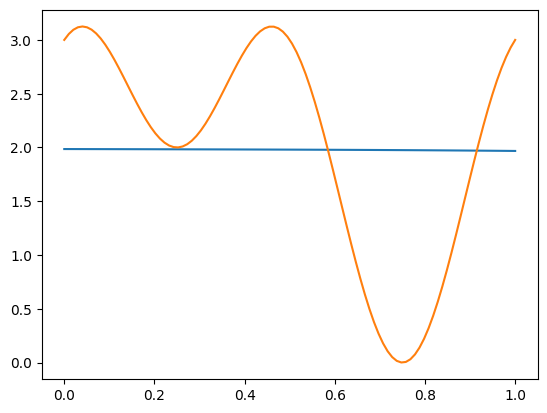

In [22]:
xs = torch.linspace(0, 1, 100)
ts = torch.zeros(100)
graph_points = torch.stack((ts, xs), axis=-1)
#print(graph_points)
T_nn = pinn.forward(graph_points).view(100)
plt.plot(xs.numpy(), T_nn.detach().numpy())
T_real = f_real(ts, xs).view(100)
plt.plot(xs.numpy(), T_real.numpy())

plt.plot()
plt.show()